**Summary**  
I. Target variable analysis  
II. Manual exploration  
III. Dependent variables analysis  
IV. Missing values & Outliers  
V. Outliers  
VI. Feature engineering + distribution transformation + one-hot encoding

**Related files**  
EDA.xlsx


## Setup

In [343]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
from utils import cramers_V
from scipy.stats import norm


data_folder = "./data/"
df_train = pd.read_csv(data_folder + "train.csv")
df_test = pd.read_csv(data_folder + "test.csv")
target = 'SalePrice'

print('df train shape is : ',df_train.shape)
print('df test shape is : ',df_test.shape)

# Aggregation of variables per type : numerical, orginal or categorical
cat_var = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num_var = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
ord_var = ['OverallQual', 'OverallCond', 'GarageCars']

print('df train shape is : ',df_train.shape)
print('df test shape is : ',df_test.shape)
df_train.head()

df train shape is :  (1460, 81)
df test shape is :  (1459, 80)
df train shape is :  (1460, 81)
df test shape is :  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## I. Target variable analysis

Missing value : 0
count    1460.000000
mean      180.921196
std        79.442503
min        34.900000
25%       129.975000
50%       163.000000
75%       214.000000
max       755.000000
Name: SalePrice, dtype: float64


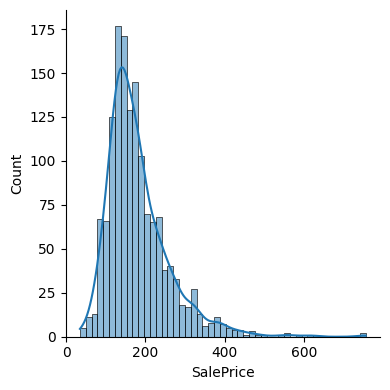

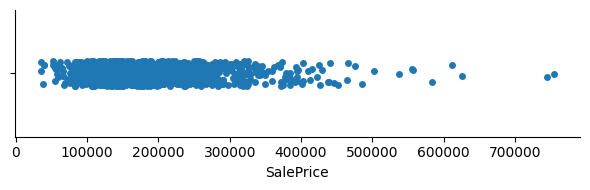

In [344]:
y_train = df_train[target]/1000
print(f'Missing value : {sum(y_train.isnull())}')
print(y_train.describe())
sns.displot(y_train, kde = True, height=4);
sns.catplot(df_train,x=target, height=2, aspect=3);

**Conclusion**
- No missing values   
- min: $34k, mean: $180k, max $755k. Seems reasonnable regarding real estate prices in the US => No strange value in the dataset
- Distribution positively skewed. Log transformation ?
- 2 values are far from the distribution (>700k). We'll keep that in mind for the outliers analysis

## II. Manual exploration  
The goal in this part is to build a preliminary understanding of the dataset



In [345]:
# Missing values
total = df_train.isnull().sum().sort_values(ascending=False)
percent = df_train.isnull().sum().sort_values(ascending=False)/len(df_train)*100
missing_data=pd.concat((total,percent), axis=1, keys = ['Total', 'percent'])
missing_data.head(20)


,Total,percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945


19 variables have missing data:  
-  missing > 40% : 5 variables, seems to be related to housing features that is not present in all houses (Pool, Fence, etc.)  
-  20% > missing > 5% : LotFrontage and all variables associated with Garage. Seems like all the missing in the GarageX feature are the same and are probably associated with houses without garages  
- 5% > missing: 7 variables, most of them related to Basement. Houses without basement ?

It seems the dataset is not corrupted in the sense that the missing values seem to correspond to missing features in reality. We could transform the missing values by "Absent"

To get a sense of the overall dataset, we performed a characterization of all the variables in ***EDA.xlsx***  
Each variable is characterized as :  
- Numerical / categorical / ordinal  
- Segment : is it a variable related to the location, the general building characteristics, housing space ?
- Dependence expectation : high / medium / low


As a result, we identified 8 variables that would play a significant role in the prediction : Neighborhood, OverallQual, OverallCond, TotalBsmtSF, GrLivArea, GarageCars, GarageArea, YrSold  

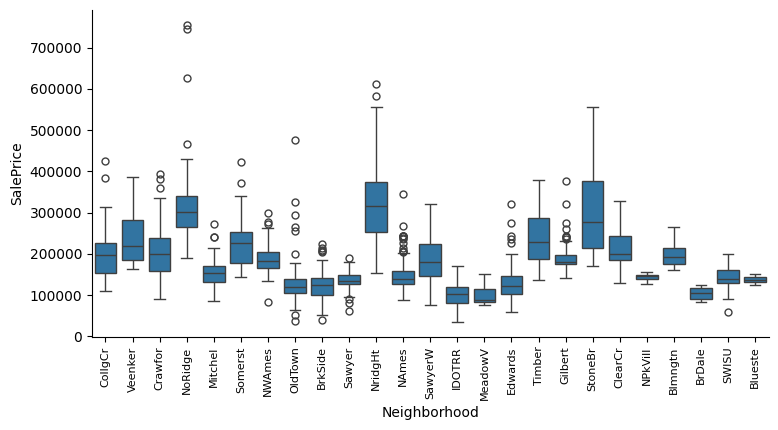

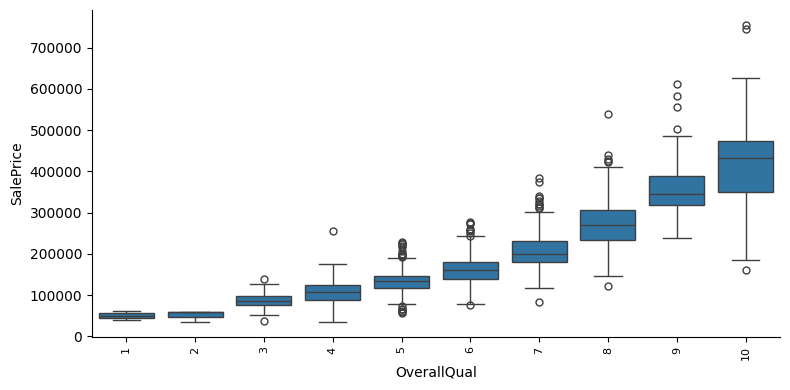

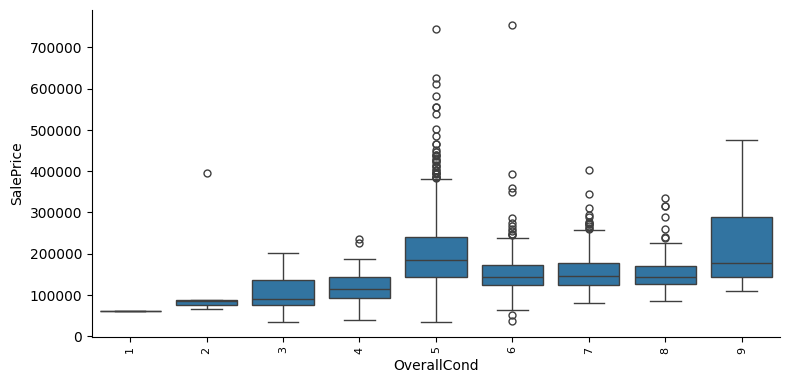

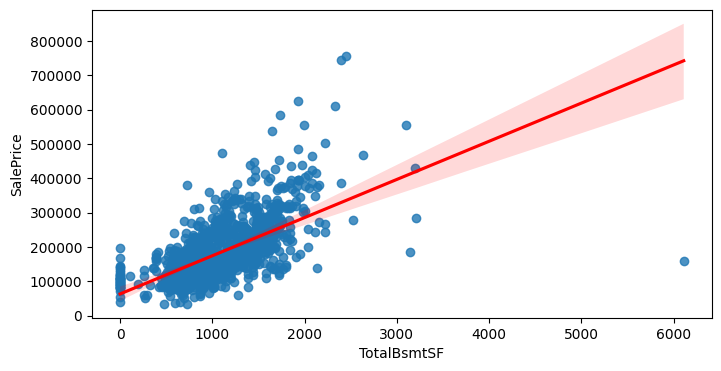

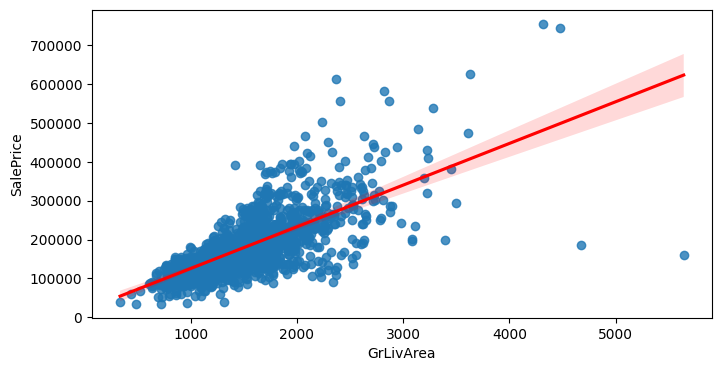

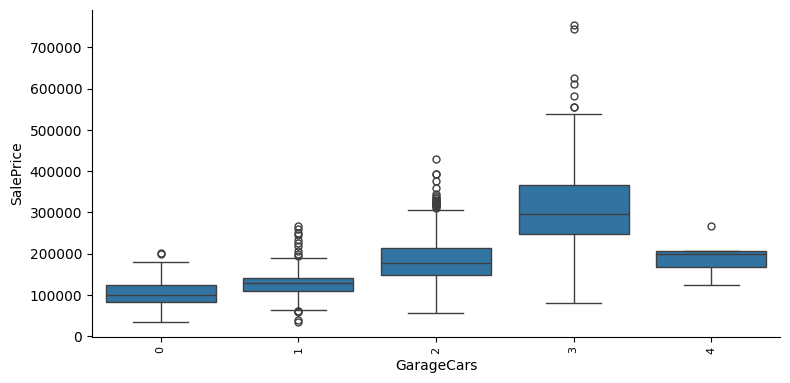

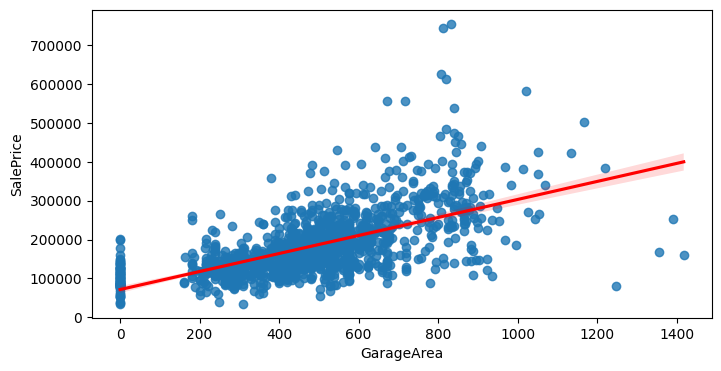

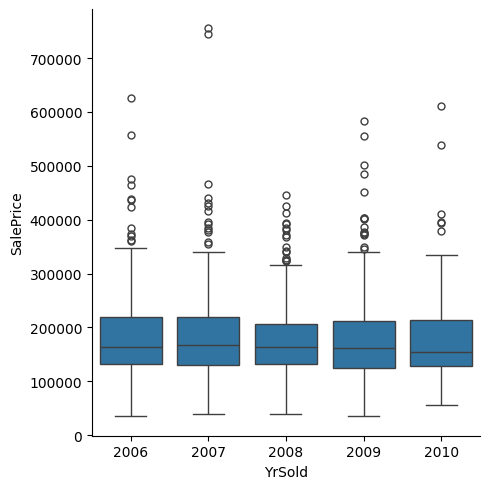

In [346]:
var = ['Neighborhood', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'YrSold']

for v in var:
    if v == 'YrSold':
        ax = sns.catplot(data=df_train, x=v, y=target, kind="box")
        plt.show()
    elif v in num_var:
        plt.figure(figsize=(8,4))
        sns.regplot(df_train,x= v, y=target, line_kws = {"color": "red"})
        plt.show()
    else:
        ax = sns.catplot(data=df_train, x=v, y=target, kind="box", height=4,aspect=2)
        ax.set_xticklabels(rotation=90, fontsize = 8) 
        plt.show()

Based on the visualization, it seems those variables are good predictors except ***YrSold***
 
- ***Neighborhood***: This feature seems to have a good discrimination power
- ***OverallQual***: Positif relationship with SalePrice, quadratic relationship ?
- ***OverallCond***: Seem to have little  
- ***TotalBsmtSF***: Clear positive relationship, quadratic relationship ? A lot of 0 that must correspond to accomodation with no basement
- ***GrLivArea***: Clear positive relationship, linear or exponential ?
- ***GarageCars***: Positive relationship up to 3 cars. 4 cars correspond to a different type of housing ?
- ***GarageArea***: Clear positive relationship, is the information duplicated with GarageCars ?  
- ***YrSold*** : Price distribution doesn't seem to vary much over the years

In [347]:
fig = px.scatter_3d(df_train, x='GrLivArea', y='Neighborhood', z=target, color=target, size_max=10)
fig.show()

**Conclusion**  
- It seems we can have reasonnable predictions by just fitting a model using 'GrLivArea' and 'Neighborhood'  
- Errors are wider alongside big values of SalePrice, we could adress by distribution transformations  
- We can already detect 4 outliers in the ***SalePrice vs GrLivArea plot***

## III. Variables Analysis  
In this part we'll use analytical tools to quantify depencies

### a. Numerical & ordinal features

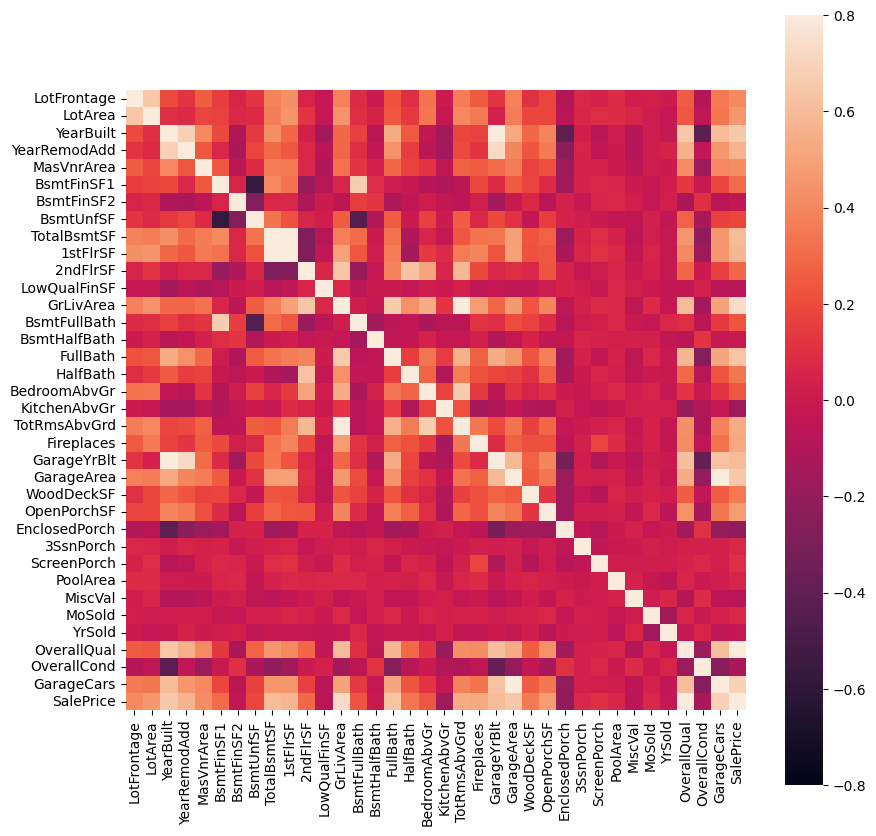

In [348]:
df_num= df_train[num_var + ord_var +[target]]
corrmat = df_num.corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, square=True, vmax=0.8, vmin=-0.8);

We identify some groups of variables that are correlated:
- LotFrontage, LotArea
- YearBuilt, YearRemodAdd, GarageYrBuilt
- TotalBsmtSF, 1stFlrSF  
- TotalGrLivAre, TotRmsAbvGrd, 2ndFlrSF
- GarageArea, GarageCars

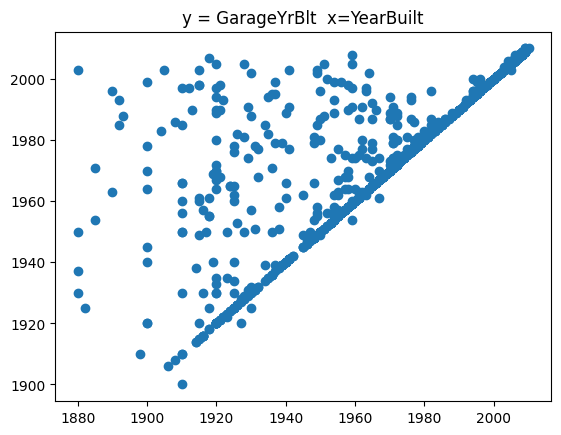

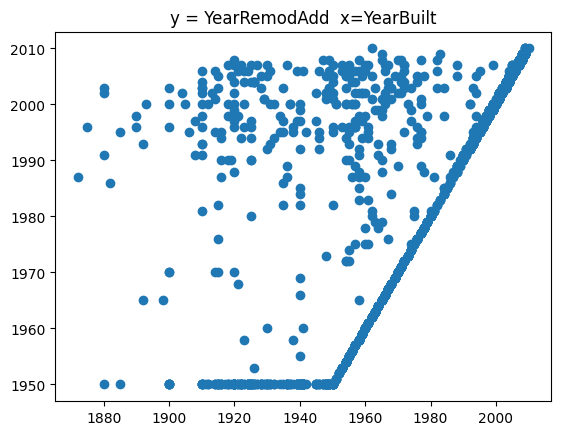

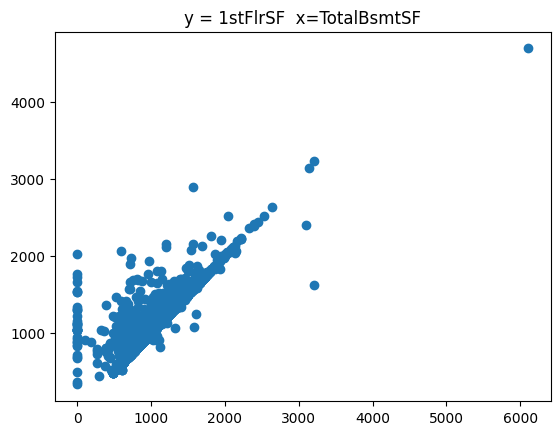

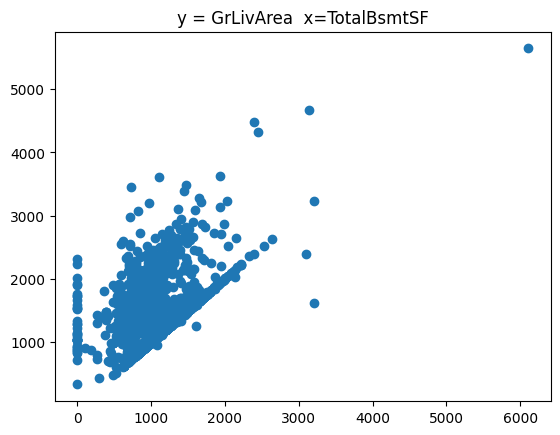

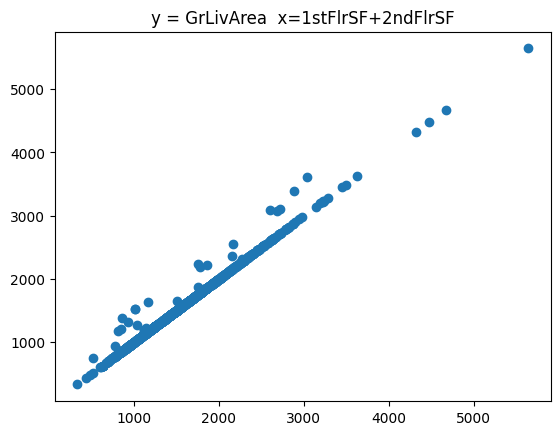

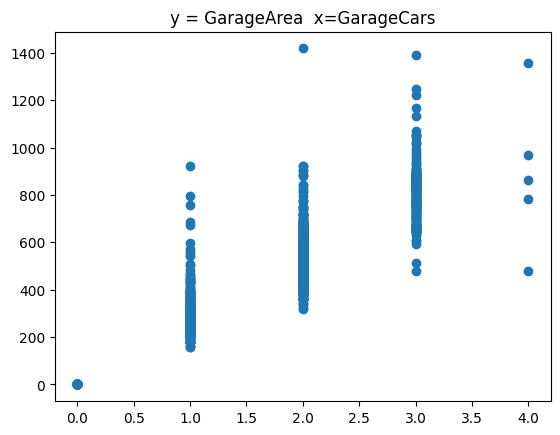

In [349]:
v1,v2 = 'YearBuilt', 'GarageYrBlt'
plt.scatter(df_train[v1], df_train[v2])
plt.title(f'y = {v2}  x={v1}')
plt.show()

v1,v2 = 'YearBuilt', 'YearRemodAdd'
plt.scatter(df_train[v1], df_train[v2])
plt.title(f'y = {v2}  x={v1}')
plt.show()


v1,v2 = 'TotalBsmtSF', '1stFlrSF'
plt.scatter(df_train[v1], df_train[v2])
plt.title(f'y = {v2}  x={v1}')
plt.show()
v1,v2 = 'TotalBsmtSF', 'GrLivArea'
plt.scatter(df_train[v1], df_train[v2])
plt.title(f'y = {v2}  x={v1}')
plt.show()

plt.scatter(df_train['1stFlrSF']+df_train['2ndFlrSF'], df_train['GrLivArea'])
plt.title(f'y = GrLivArea  x=1stFlrSF+2ndFlrSF')
plt.show()

v1,v2 = 'GarageCars', 'GarageArea'
plt.scatter(df_train[v1], df_train[v2])
plt.title(f'y = {v2}  x={v1}')
plt.show()

As per those visualization, we identy many relationship:
- GarageCars,GarageArea: are very similar => *For a certain area we can put x cars*  
- YearBuilt < GaraYrBlt  
YearBuilt < YearRemodAdd => Housing is built first
- 1stFlrSF > TotalBsmtSF, 1stFlrSF + 2ndFlrSF = GrLivArea, GrLivArea > TotalBsmtSF  
 => Those are logical relationship between areas

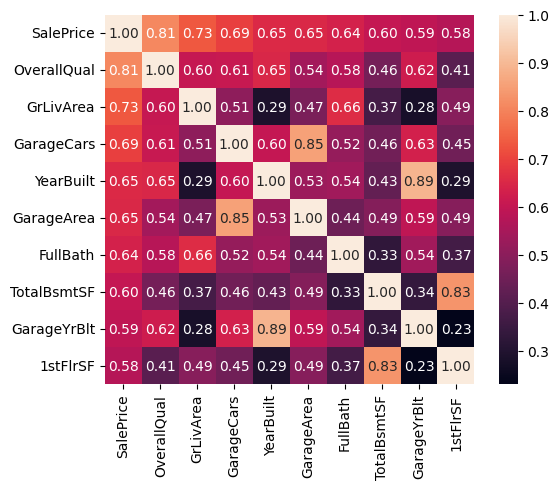

In [350]:
k = 10
cols = corrmat.nlargest(k, target).index
cm = df_train[cols].corr(method='spearman')
# cm = np.corrcoef(df_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

- GrLivArea, TotalBsmtSF, 1stFlrSF are good features, let's see if we can combine them in the feature engineering part  
- GarageCars and GarageArea are very correlated, we'll keep GarageCars  
- YearBuilt and GarageBuilt are very correlated, we'll keep YearBuilt
- We keep OverallQual & FullBath

**Conclusion : numerical and ordinal variable analysis**  
Except FullBath, all those variables are about the quality and the size of the house. That makes sense since this is the first thing that comes to mind when we think about buying a house.

In [351]:
var_num_selected = ['GrLivArea','1stFlrSF', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'YearBuilt']

### b. Categorical variables

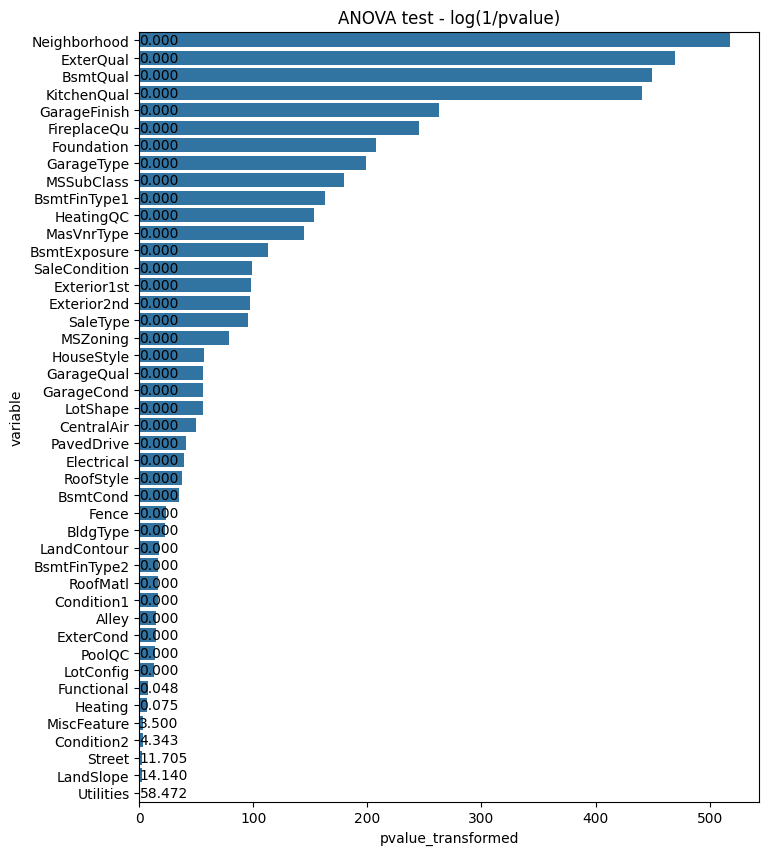

In [352]:
anova_results = []
df_temp = df_train.copy()
for v in cat_var:
    df_temp[v]=df_temp[v].fillna('no')
    cat = df_temp[v].unique()
    data = [ df_temp[df_temp[v]==c][target] for c in cat]
    fvalue, pvalue = stats.f_oneway(*data)
    anova_results.append((v, fvalue, pvalue))
df_anova = pd.DataFrame(anova_results, columns=['variable', 'fvalue', 'pvalue'])
df_anova['pvalue_transformed']=df_anova['pvalue'].apply(lambda x:np.log(1/x))

df_anova.sort_values('pvalue_transformed', inplace=True,ascending = False)
plt.figure(figsize=(8,10))
ax = sns.barplot(data=df_anova, y='variable', x='pvalue_transformed')
for index, value in enumerate(df_anova['pvalue']):
    ax.text(value, index, f'{value*100:.3f}', ha='left', va='center')
plt.title('ANOVA test - log(1/pvalue)')
plt.show()

Many variables have a significant impact on the SalePrice. We'll study the 10 most important in order to keep a low number of variables and enhance interpretability

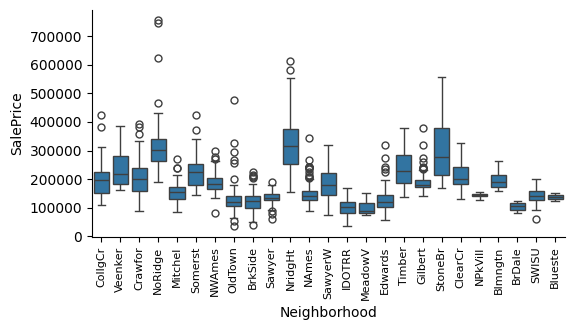

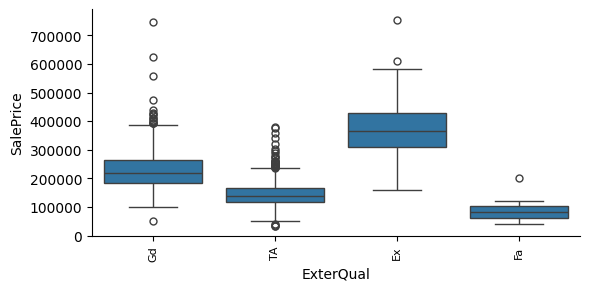

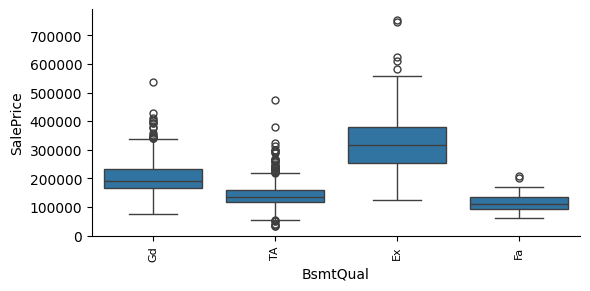

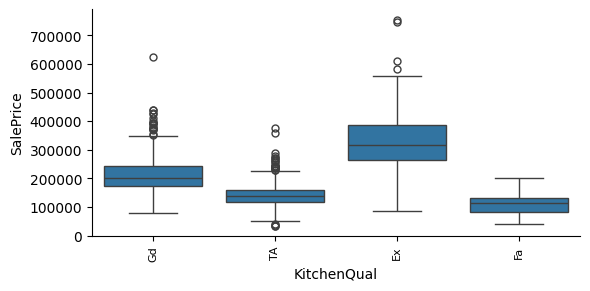

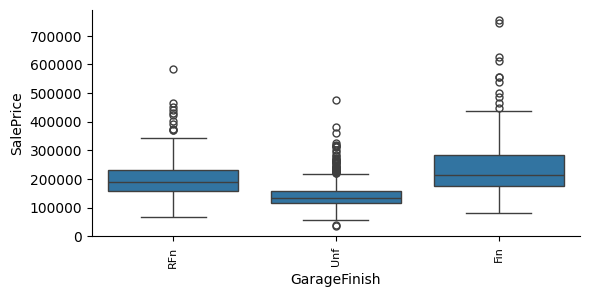

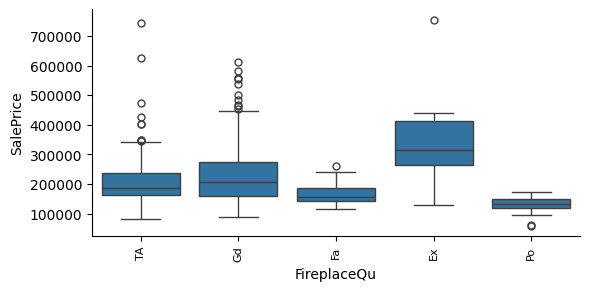

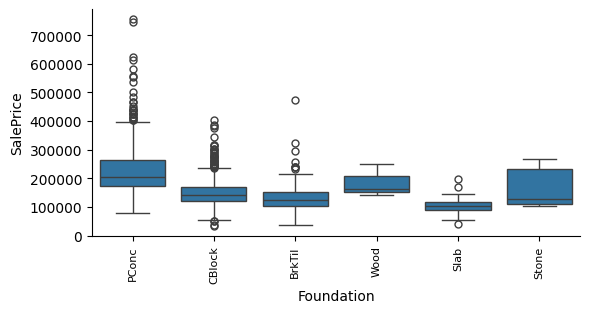

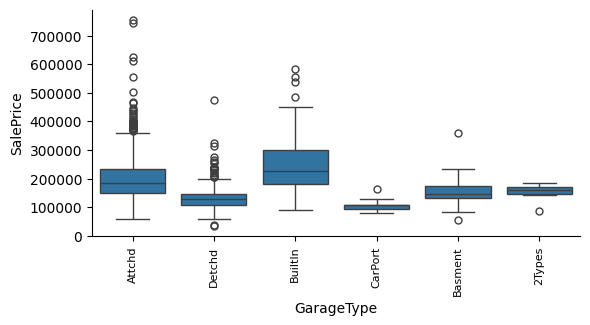

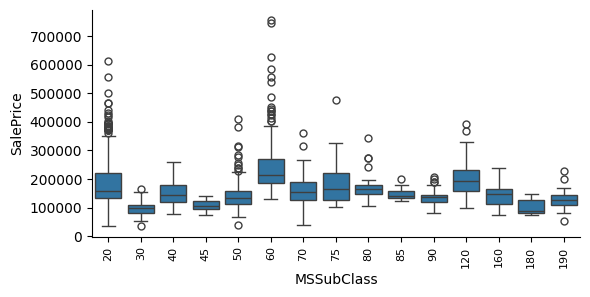

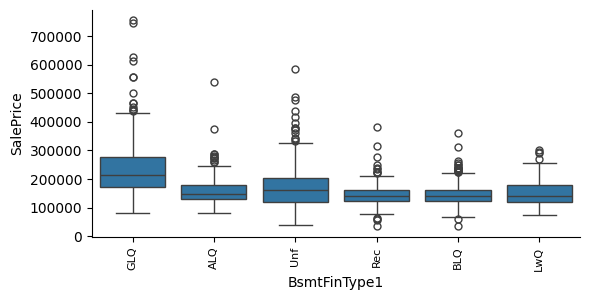

In [353]:
k = 10 # Number of variables selected

var_cat_selected = list(df_anova['variable'].iloc[:k])

for v in var_cat_selected:
    ax = sns.catplot(data=df_train, x=v, y=target, kind="box", height=3,aspect=2)
    ax.set_xticklabels(rotation=90, fontsize = 8)
    plt.show()

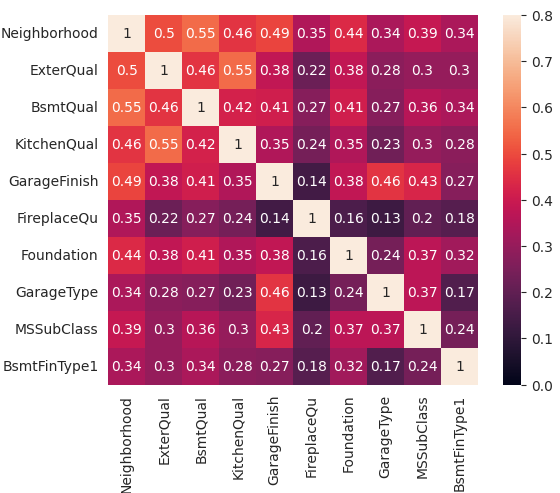

In [354]:
df_temp = df_train[var_cat_selected]

rows= []
for var1 in df_temp:
  col = []
  for var2 in df_temp :
    cramers =cramers_V(df_temp[var1], df_temp[var2]) 
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
df_cramer = pd.DataFrame(cramers_results, columns = df_temp.columns, index =df_temp.columns)

with sns.axes_style("white"):
  ax = sns.heatmap(df_cramer,vmin=0., vmax=0.8, square=True, annot=True)

- As per ou intuition, Neighborhood is an important feature
- ExterQual, BsmtQual, KitchenQual: features about general condition of housing
- BsmtQual, BsmtFinType1, Foundation : very correlated  
- GarageType, GarageFinish : very correlated
- FireplaceQu : We wonder if FireplaceQu is present in a significant number of housing  
- MSSubClass


Other than the Cramers'V, as per the visualization, it seems ExterQual, BsmtQual, KitchenQual, GarageFinish have similar information

Finally, we are going to keep : Neighborhood, ExterQual, GarageFinish, FireplaceQu, MSSubClass

**Conclusion: Categorical variables analysis**
  
We keep the following variables:
- As per ou intuition, Neighborhood is an important feature
- ExterQual, BsmtQual, KitchenQual, Fundation: features about general condition of housing and they are quite correlated
- GarageType, GarageFinish : features related to Garage. Quite correlated
- FireplaceQu : We wonder if FireplaceQu is present in a significant number of houses
- MSSubClass
- BsmtFinType1

## IV. Missing values

In [355]:
var_selected = var_num_selected + var_cat_selected
total = df_train[v_selected].isnull().sum().sort_values(ascending=False)
percent = (df_train[v_selected].isnull().sum()/df_train[v_selected].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
FireplaceQu,690,0.472603
GarageFinish,81,0.055479
GarageType,81,0.055479
BsmtQual,37,0.025342
BsmtFinType1,37,0.025342
GrLivArea,0,0.000000
1stFlrSF,0,0.000000
TotalBsmtSF,0,0.000000
GarageCars,0,0.000000
FullBath,0,0.000000


We'll assume that the undifined correspond to houses without fireplace (resp. Grage and Basement)
So we will replace the undefined by ***absent***

In [356]:
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('absent')
df_train['GarageFinish']=df_train['GarageFinish'].fillna('absent')
df_train['GarageType']= df_train['GarageType'].fillna('absent')
df_train['BsmtQual']= df_train['BsmtQual'].fillna('absent')
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('absent')

## V. Outliers

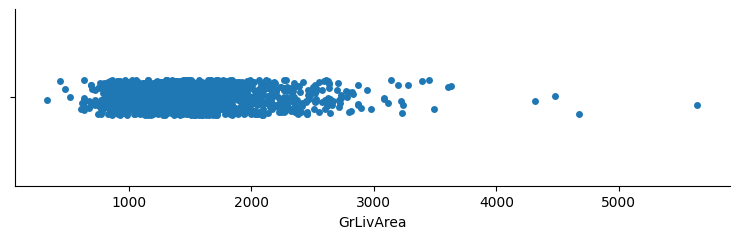

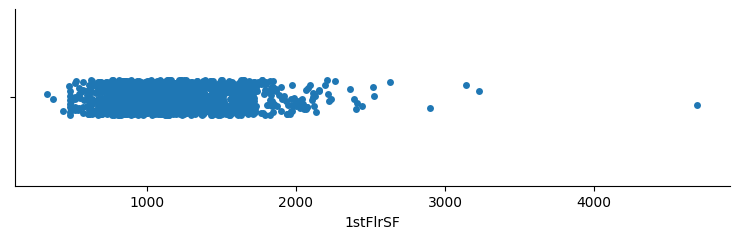

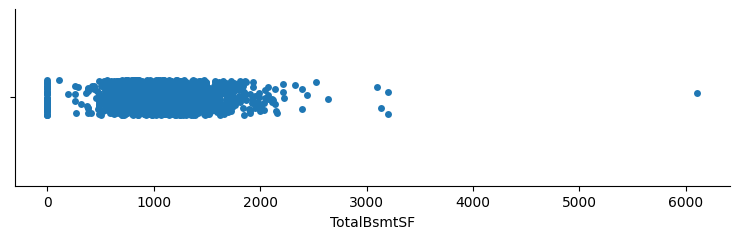

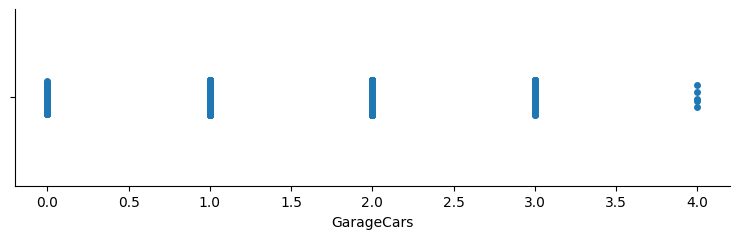

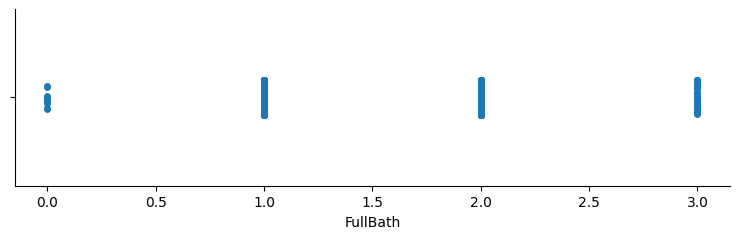

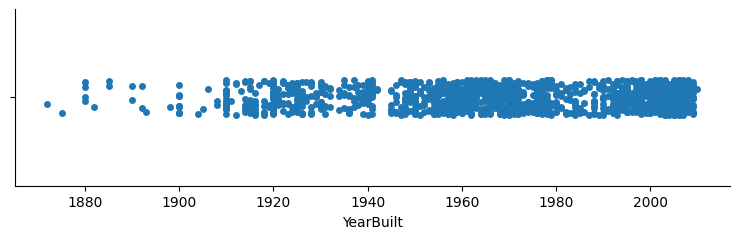

In [357]:
for v in var_num_selected:
    sns.catplot(df_train,x=v, height=2.5, aspect=3)

We can see 3 observations far from the center of the distribution

In [358]:
print(df_train[df_train['GrLivArea']>5000]["Id"])
print(df_train[df_train['TotalBsmtSF']>5000]["Id"])
print(df_train[df_train[target]>700000]["Id"])

1298    1299
Name: Id, dtype: int64
1298    1299
Name: Id, dtype: int64
691      692
1182    1183
Name: Id, dtype: int64


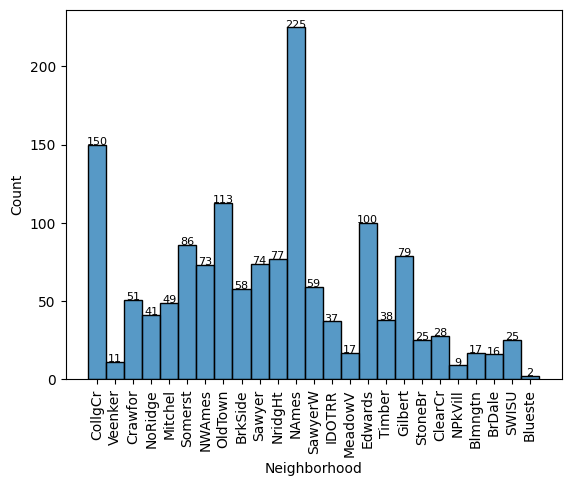

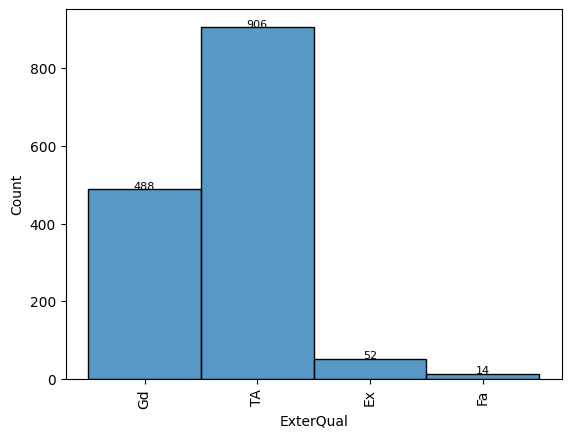

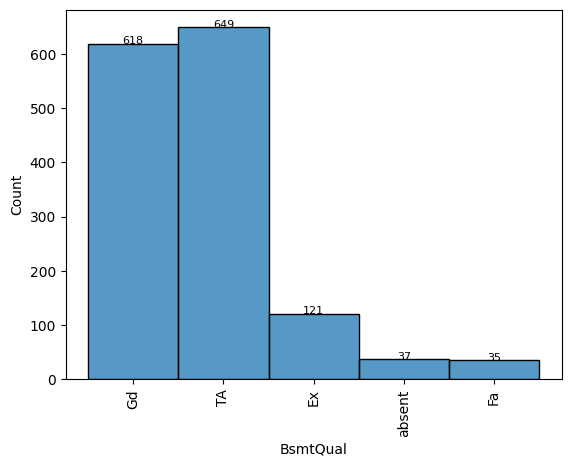

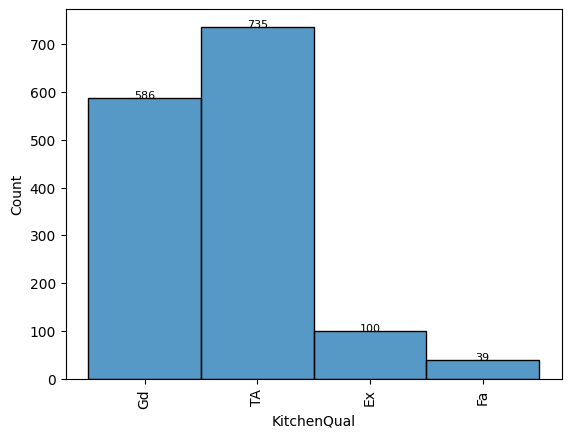

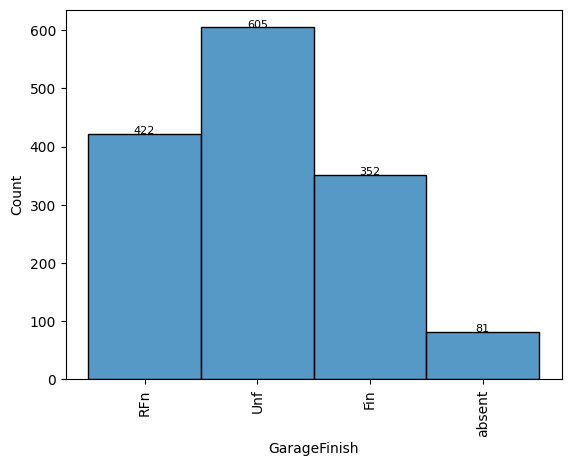

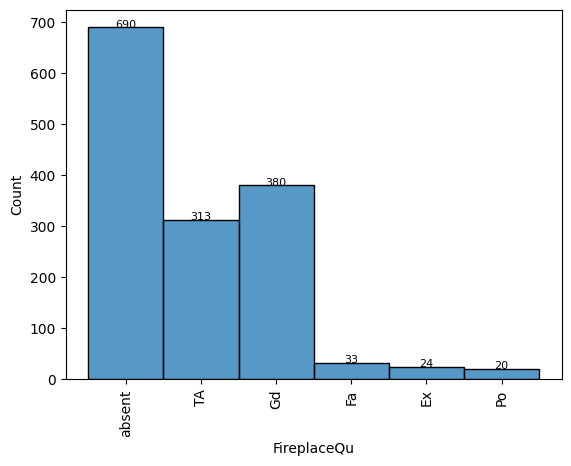

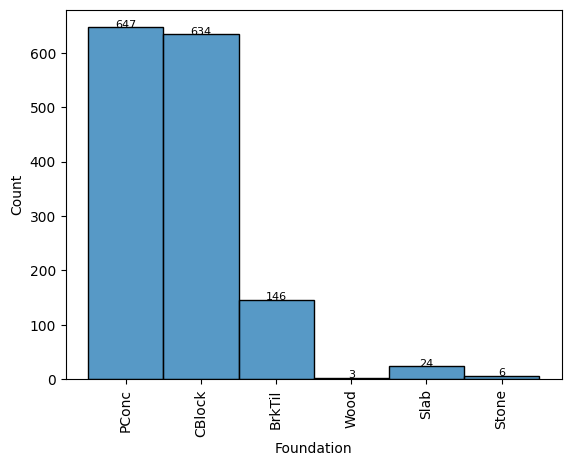

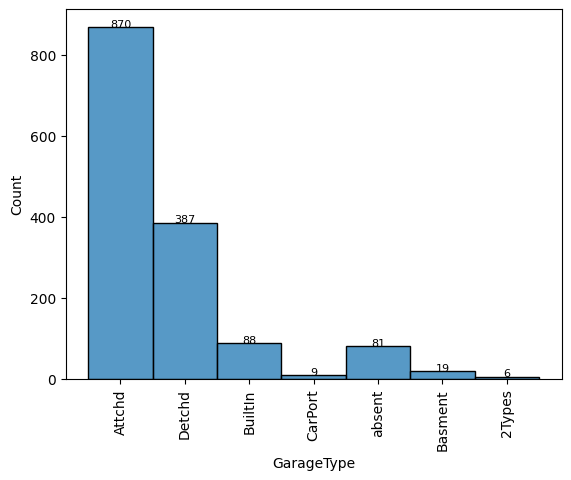

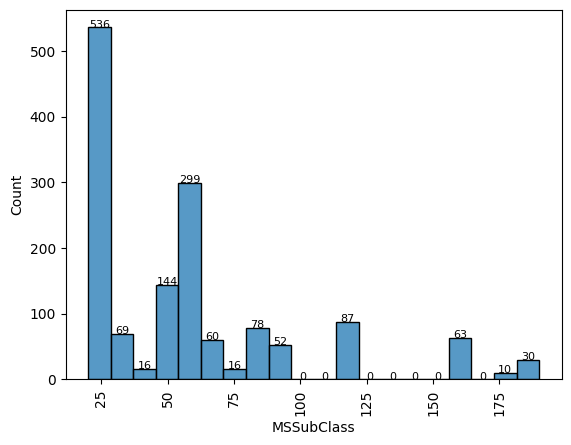

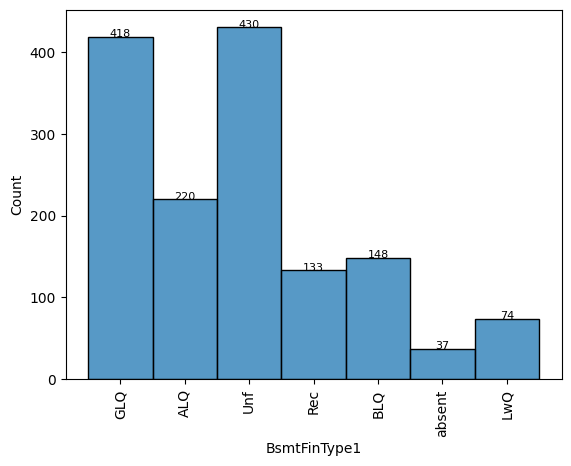

In [359]:
for v in var_cat_selected:
    ax=sns.histplot(df_train[v])
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=8, color='black')
    plt.xticks(rotation=90)
    plt.show()

Some Caterogies are really imbalanced: 
- ExterQual : we'll gather
    - Ex & Gd (excellent and good)
    - Fa & TA (fair, typical average)
- BsmtQual : we'll gather
    - Ex & Gd
    - Fa & TA
- KitchenQual: we'll gather
    - Ex & Gd
    - Fa & TA
- FireplaceQu: we'll gather
    - Ex & Gd
    - Fa & TA & Po
- Foundation: we'll gather
    - Wood, Stone, Slab > other
- GarageType
    - Attachd, 2Types & Basment
    - CarPort & absent

In [360]:
df_train['ExterQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['BsmtQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['KitchenQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['FireplaceQu'].replace({'Ex': 'Gd', 'Fa': 'TA', 'Po':'TA'}, inplace=True)
df_train['Foundation'].replace({'Wood': 'Other', 'Stone': 'Other', 'Slab':'Other'}, inplace=True)
df_train['GarageType'].replace({'2Types': 'Attchd', 'CarPort': 'absent'}, inplace=True)


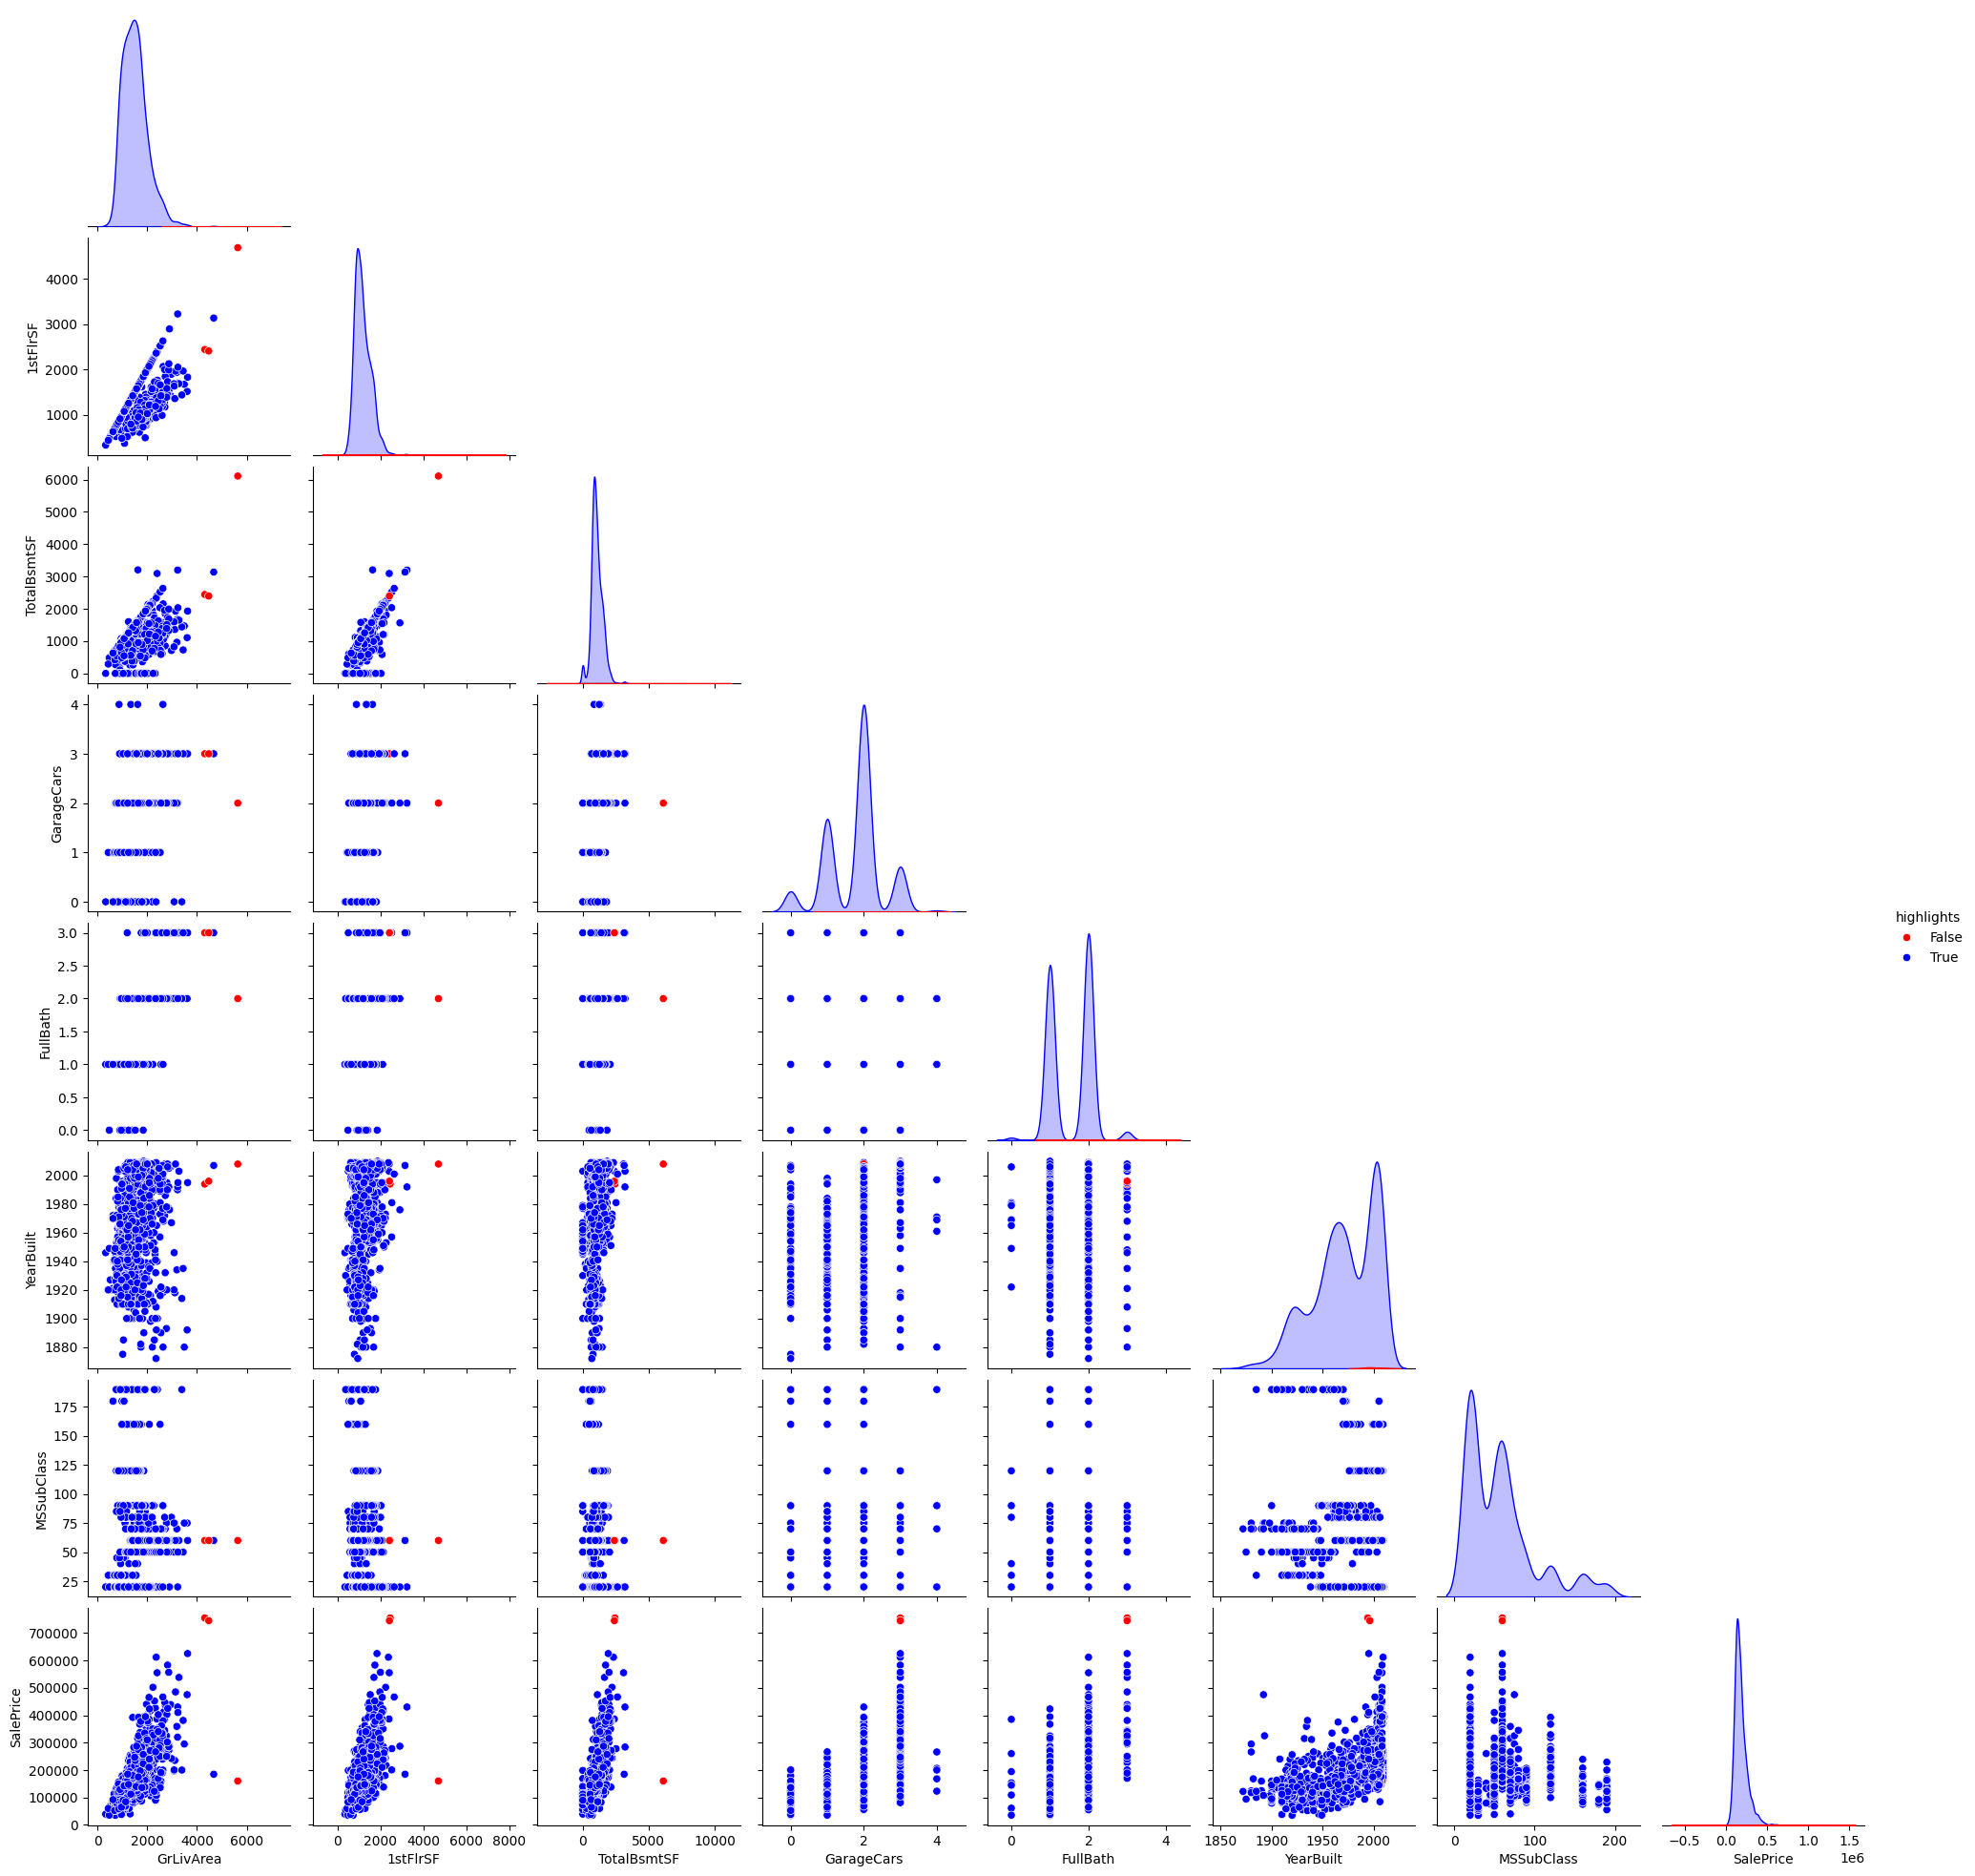

In [361]:
id_highlights = [1299,692,1183]

df_temp = df_train[var_selected+[target]].copy()
df_temp["highlights"] = ~df_train["Id"].isin(id_highlights)
colot_palette = {True: 'blue', False: 'red'}

sns.pairplot(df_temp, corner=True, hue = 'highlights', palette=colot_palette)

In [362]:
drop_id = [1299,692,1183]
df_train = df_train[~df_train["Id"].isin(drop_id)]

**Conclusion Outliers**  
We removed 3 observations. We corrected some imbalanced classes. Some are still imbalanced but for now we'll keep the categories as it is

## VI. Feature engineering + distribution transformation + one hot encoding

### a. New features

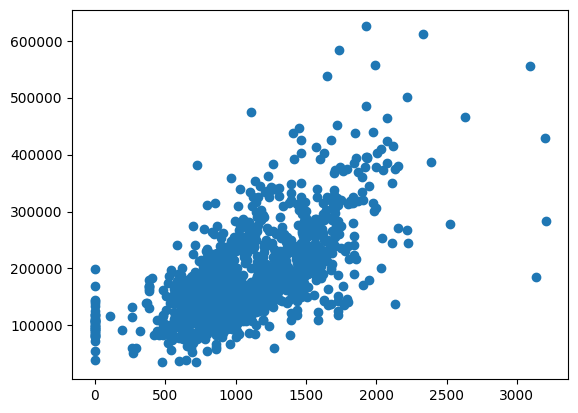

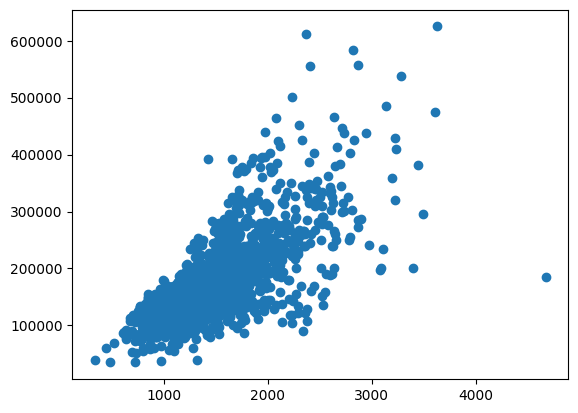

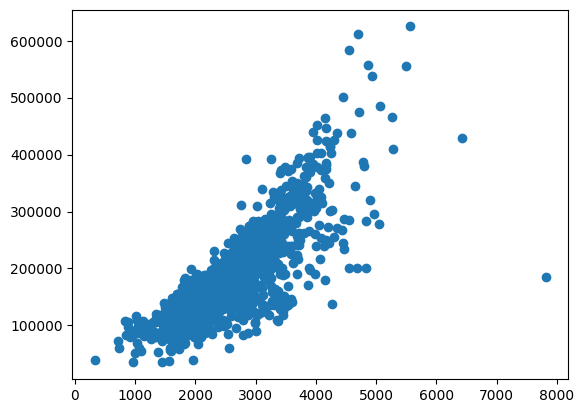

,TotalBsmtSF,GrLivArea,TotArea,SalePrice
TotalBsmtSF,1.000000,0.407735,0.803664,0.641170
GrLivArea,0.407735,1.000000,0.871053,0.710911
TotArea,0.803664,0.871053,1.000000,0.808221
SalePrice,0.641170,0.710911,0.808221,1.000000


In [363]:
df_temp = df_train.copy()
df_temp["TotArea"] = df_temp['GrLivArea']+df_temp['TotalBsmtSF']

plt.scatter(df_temp['TotalBsmtSF'], df_temp[target])
plt.show()
plt.scatter(df_temp['GrLivArea'], df_temp[target])
plt.show()
plt.scatter(df_temp['TotArea'], df_temp[target])
plt.show()

df_temp[['TotalBsmtSF','GrLivArea',"TotArea"]+[target]].corr()

We replace TotalBsmtSF and GrLivArea by their sum which seems more adequate to predict SalePrice. And we'll remove 1stFlrSF as well since   
**1stFlrSF+2ndFlrSF= GrLivArea**

In [364]:
for l in [var_selected,var_num_selected ]:
    l.remove('1stFlrSF')
    l.remove('GrLivArea')
    l.remove('TotalBsmtSF')
    l.append("TotArea")

df_train["TotArea"] = df_train['GrLivArea']+df_train['TotalBsmtSF']
df_train.drop(['GrLivArea','TotalBsmtSF'], axis=1, inplace=True)

### b. Distribution transformation

/var/folders/cv/8lbpg55x7gq0m33fw39zw0t40000gn/T/ipykernel_42086/3844676119.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/cv/8lbpg55x7gq0m33fw39zw0t40000gn/T/ipykernel_42086/3844676119.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




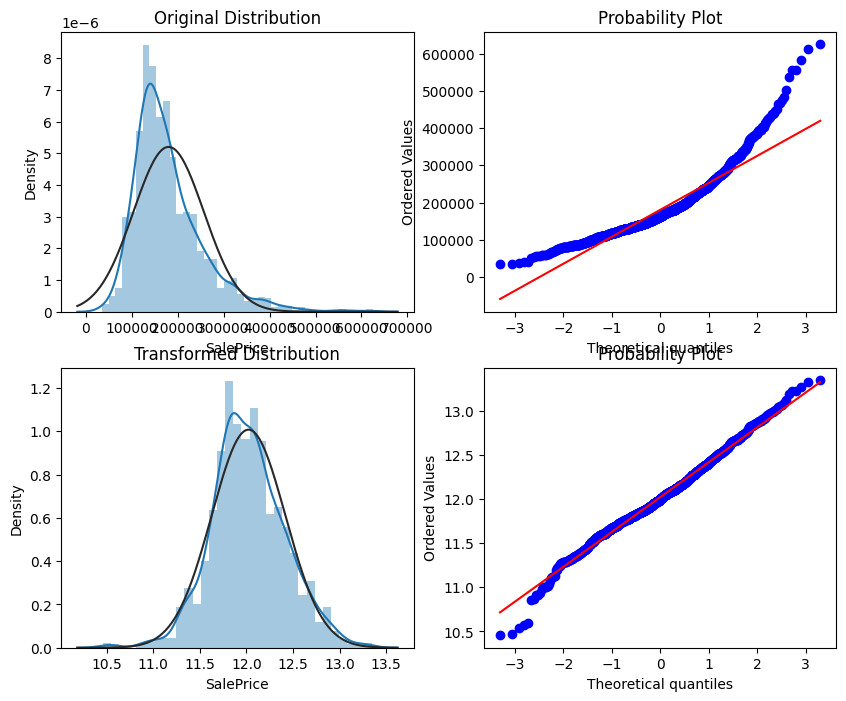

In [365]:
v = 'SalePrice'

fig, axes = plt.subplots(2, 2, figsize=(10,8))

sns.distplot(df_train[v], fit=norm, ax = axes[0,0])
axes[0, 0].set_title('Original Distribution')
stats.probplot(df_train[v], plot = axes[0,1])

y_new = np.log(df_train[v])
sns.distplot(y_new, fit=norm, ax = axes[1,0])
axes[1, 0].set_title('Transformed Distribution')
stats.probplot(y_new, plot=axes[1,1])
plt.show()

/var/folders/cv/8lbpg55x7gq0m33fw39zw0t40000gn/T/ipykernel_42086/2702053084.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/cv/8lbpg55x7gq0m33fw39zw0t40000gn/T/ipykernel_42086/2702053084.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




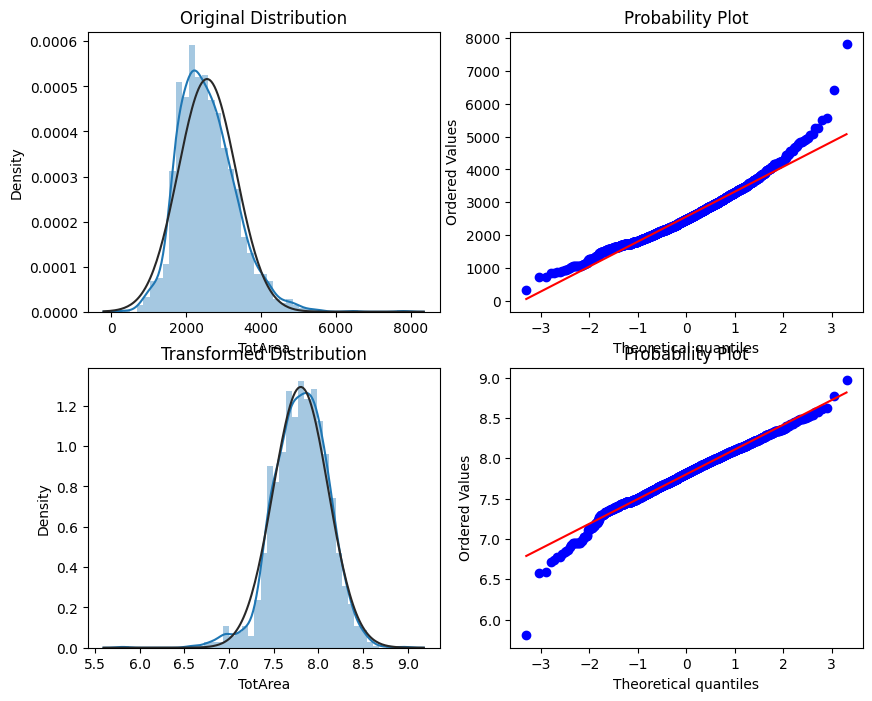

In [366]:
v = 'TotArea'

fig, axes = plt.subplots(2, 2, figsize=(10,8))

sns.distplot(df_train[v], fit=norm, ax = axes[0,0])
axes[0, 0].set_title('Original Distribution')
stats.probplot(df_train[v], plot = axes[0,1])

y_new = np.log(df_train[v])
sns.distplot(y_new, fit=norm, ax = axes[1,0])
axes[1, 0].set_title('Transformed Distribution')
stats.probplot(y_new, plot=axes[1,1])
plt.show()

In [367]:
df_train["log_TotArea"]=np.log(df_train['TotArea'])
df_train["log_price"]=np.log(df_train[target])
target = 'log_price'

for l in [var_num_selected, var_selected]:
    l.remove('TotArea')
    l.append('log_TotArea')

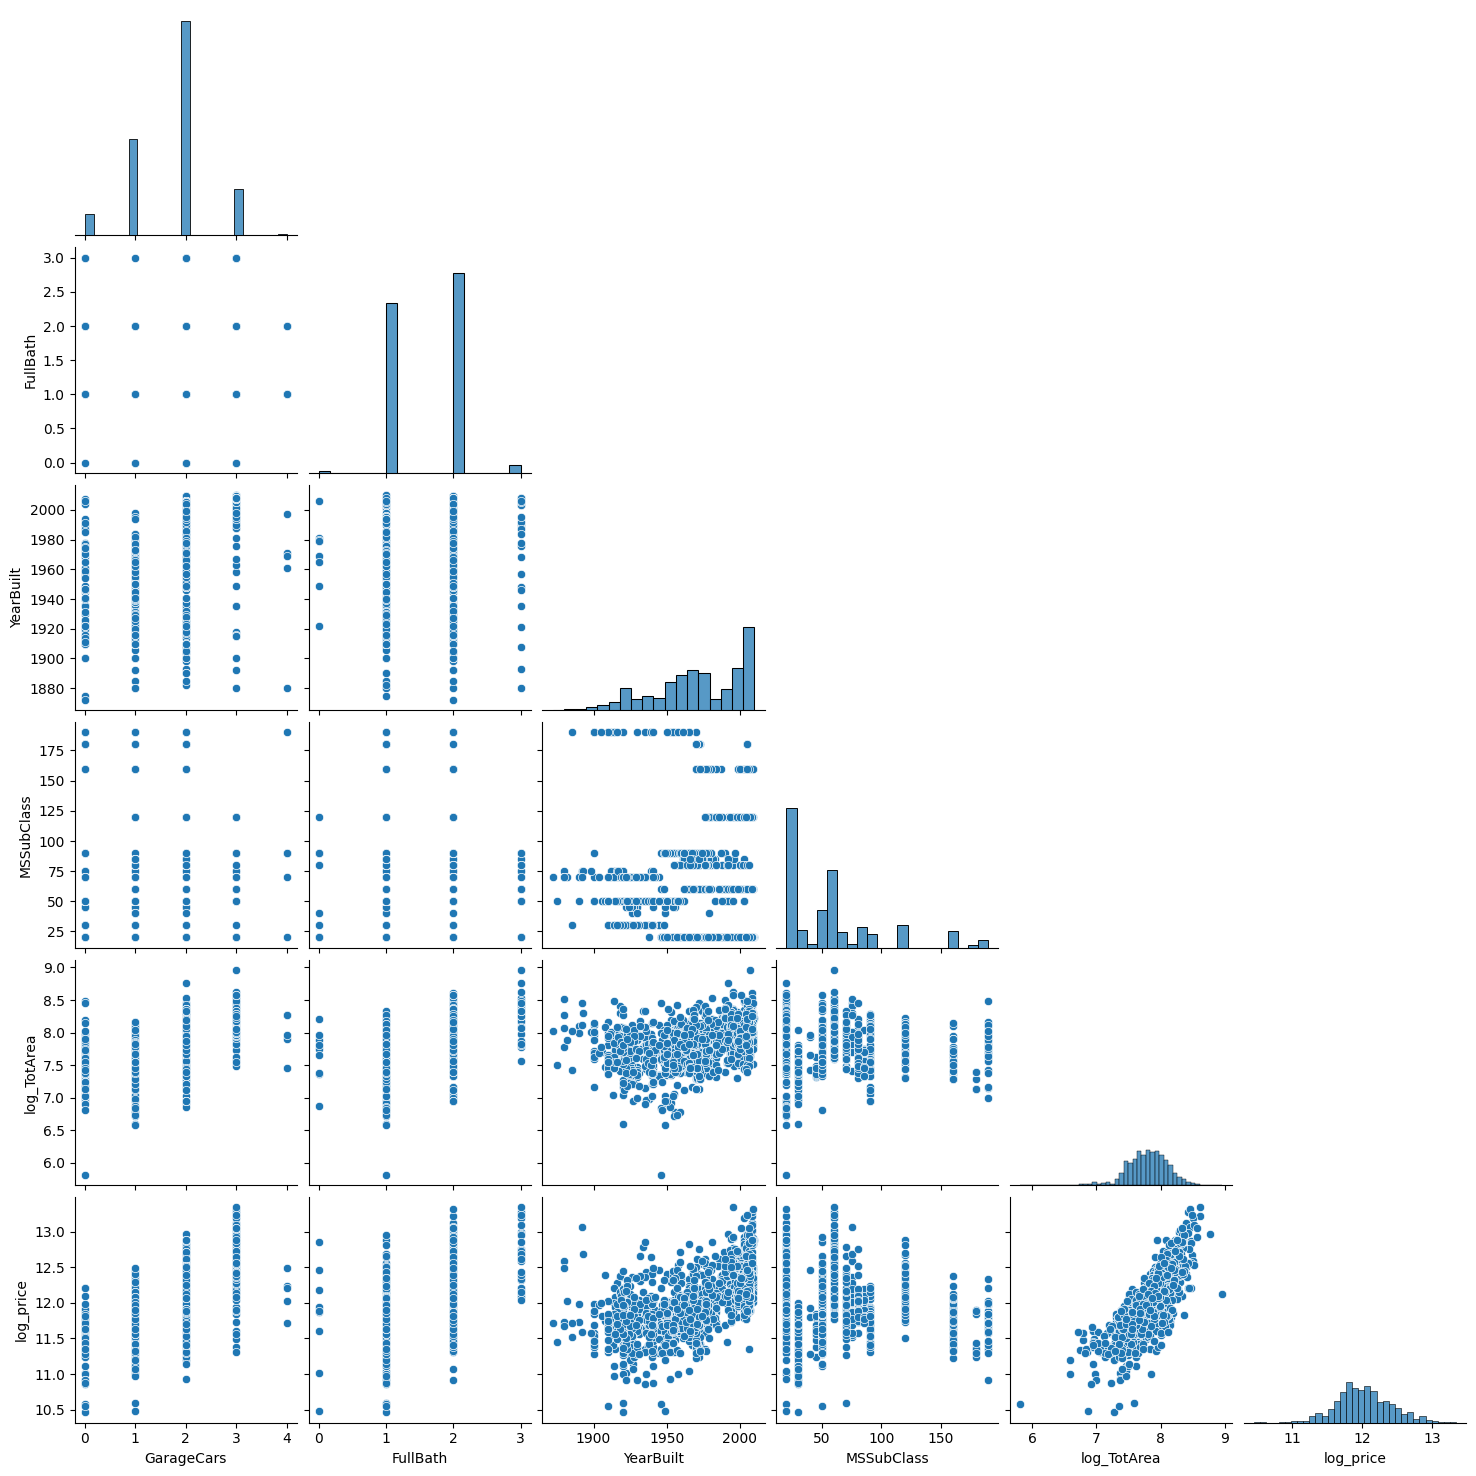

In [368]:
sns.pairplot(df_train[var_selected+[target]], corner=True)

We apply a log transformation to get closer to a normal distribution. As a result the errors have a more stable variance along the values of SalePrice.   
This will also benefit for linear regression modelling

### c. Quadratic features

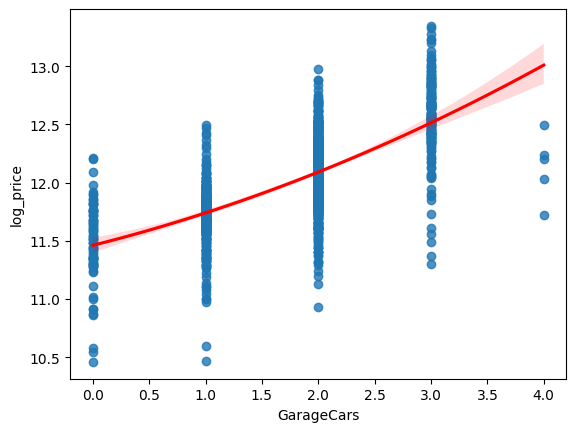

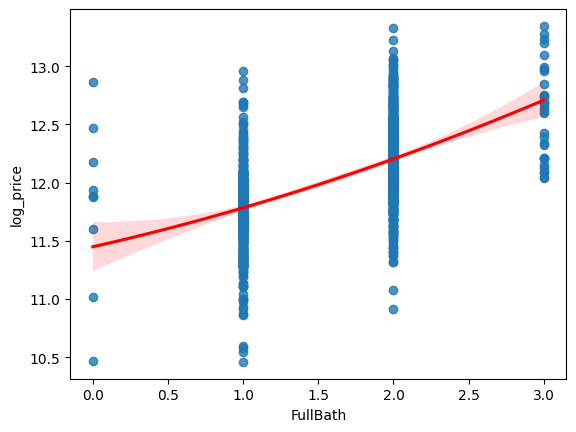

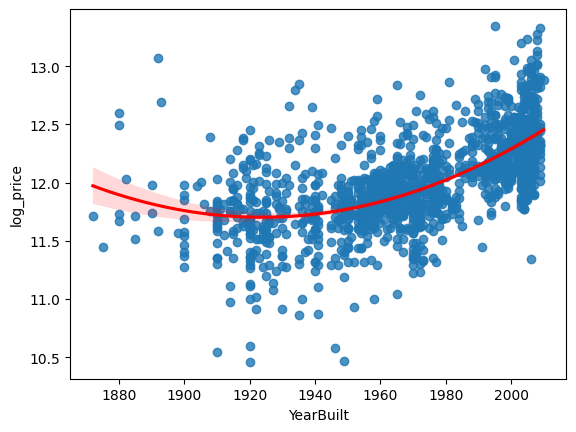

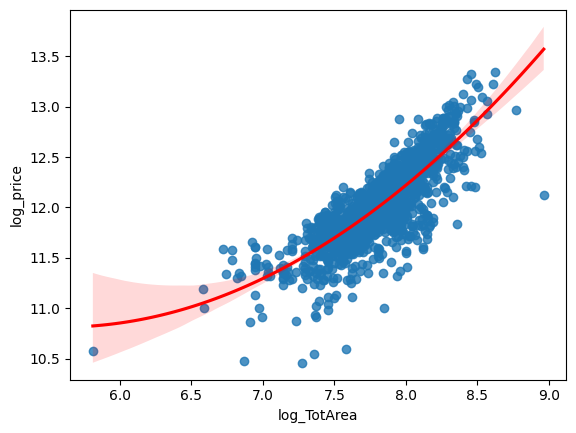

In [369]:
for v in var_num_selected:
    sns.regplot(df_train,x= v, y=target, line_kws = {"color": "red"}, order=2)
    plt.show()

It seems for log_totArea and YearBuilt we have a slight quadratic relationship. To perform Linear regression we are going to add the quadratic terms

In [370]:
# We add quadratic features for log_TotArea and YearBuilt
df_train["log_TotArea_2"] = df_train["log_TotArea"]**2
df_train["YearBuilt_2"] = df_train["YearBuilt"]**2 

for l in [var_num_selected, var_num_selected]:
    l.append('log_TotArea_2')
    l.append('YearBuilt_2')


In [374]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
df_train[var_num_selected] = scaler.fit_transform(df_train[var_num_selected])



GarageCars


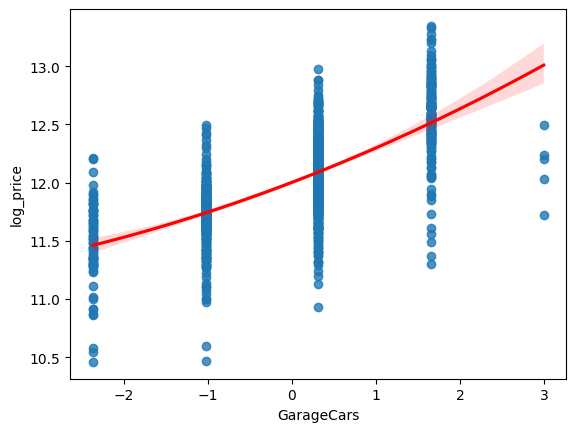

FullBath


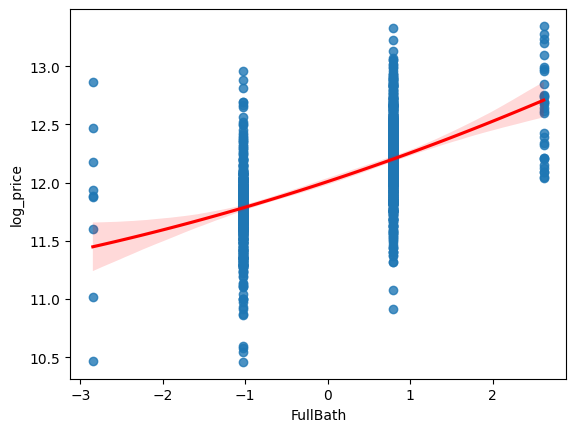

YearBuilt


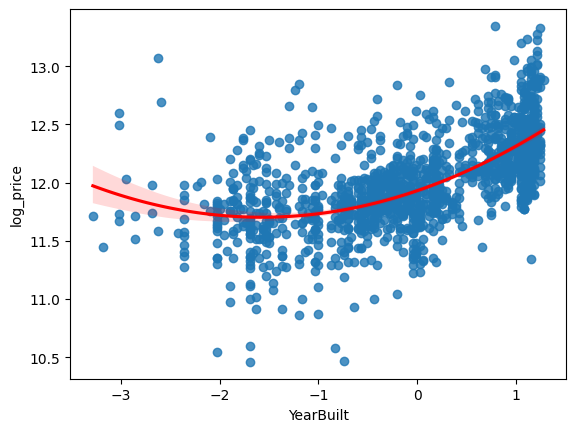

log_TotArea


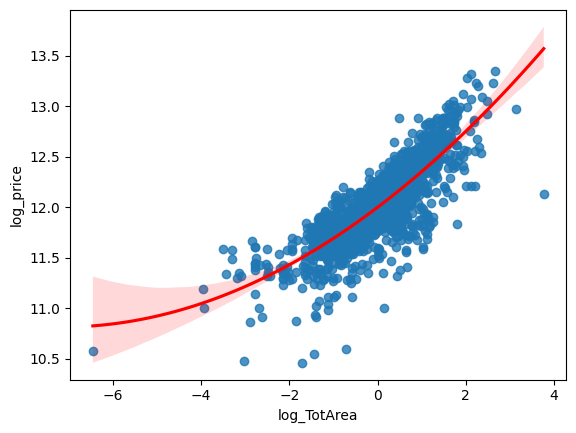

log_TotArea_2


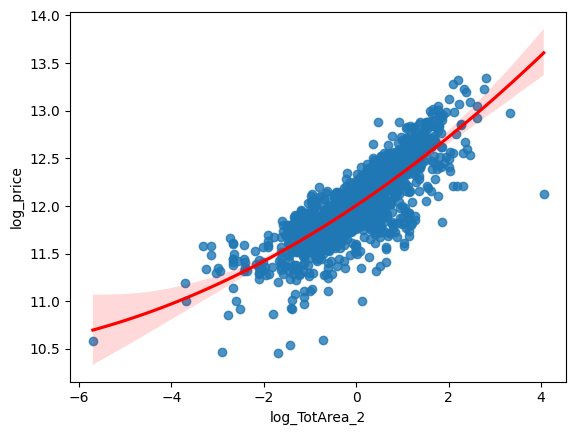

YearBuilt_2


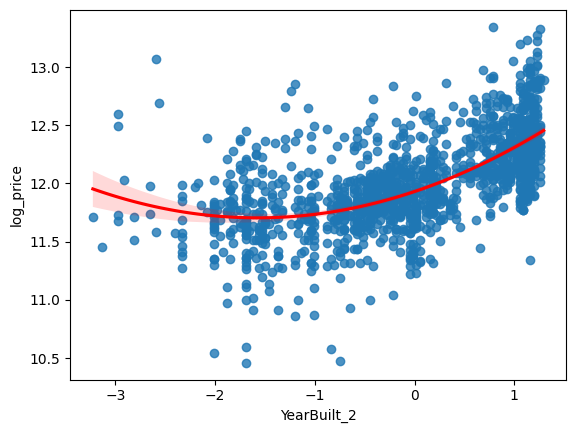

log_TotArea_2


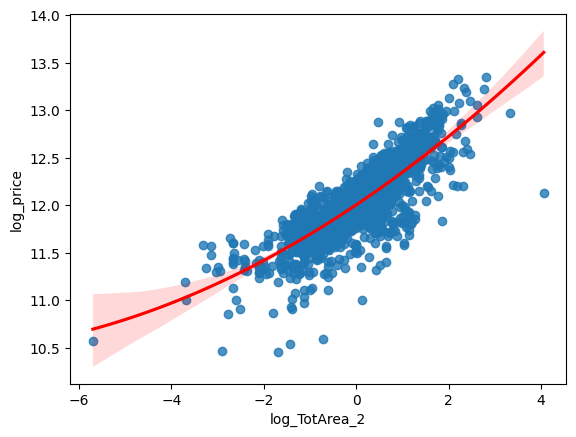

YearBuilt_2


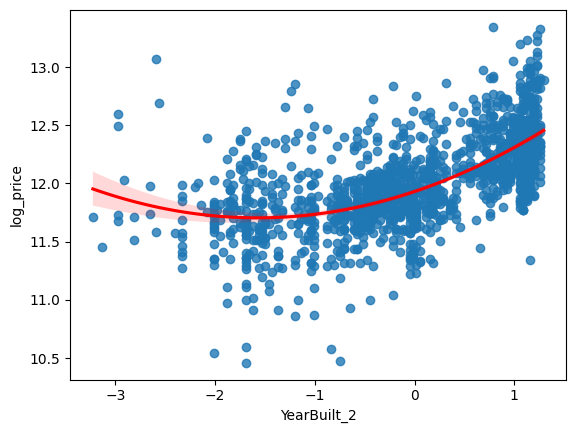

In [378]:
for v in var_num_selected:
    print(v)
    sns.regplot(df_train,x= v, y=target, line_kws = {"color": "red"}, order=2)
    plt.show()

### d. One-hot encoding


In [379]:
df_train['MSSubClass'] = df_train['MSSubClass'].astype('str')
df_train = pd.get_dummies(df_train)

## Conclusion

In the manual exploration, we saw that we could have a reasonnable prediction with neighborhood and features about the total area in the house.  
Thus, afterwards we tried to add select some variables to get a good prediction of the SalePrice, trying at the same time to keep this number low in order to avoid model variance and enhance interpretability.  
Then, we took care of possible missing values and outliers.  
Also, it seems that linear model are going to work pretty well since a lot of relationships soom to be linear/quadratic. Therefore in the feature engineering part, we made sure to transform the distributions, to scale the features and to add the quadratic terms.

We are going to use all that knowledge in order to build a predictive model in ***Model.ipynb***


